## 용어 정의 

* DSM : digital surface model의 약자이며 tiff 포멧의 이미지 파일입니다.   
    *  Pixel 구성요소 : 높이 값 (float type Z value)  
    *  Shape : 2차원 (x,y)   
* 정사영상(orthomosaic) : 현장 사진이며 tiff 포멧의 이미지 파일입니다.  
    * Pixel 구성요소 : 4개의 색상채널 Matrix [ R , G , B , A ]    
    * shape : 3차원 (x,y,4)  
  
  
> 드론이 하늘에서 찍은 사진들을 Stitching 해서 Geotiff 태그(지리정보)를 입힌것이 정사영상입니다.  
> DSM은 이 정사영상의 각 픽셀들에 대한 높이(Z)값을 담은 파일입니다.  
> 두 파일은 픽셀 구성요소와 매트릭스 차원 구성을 제외하고 모두 동일합니다.   
  
---
  
* 양수화 : 음수와 양수로 구성된 숫자 분포의 최소값이 0이 되도록 분포를 0 위로 올려서 음수가 없도록 하는것입니다.  
  
>  Min-Max Normalization 연산을 위해서 분포는 유지하되, 음수가 없도록 하는 트릭입니다.

## Colormap  
Turbo 컬러맵을 사용합니다.  
[컬러맵 생성하기 - colormap.ipynb](colormap.ipynb)
  
*높이가 낮을수록 짙은 파란색 , 높이가 높을수록 짙은 빨간색으로 표현할것입니다.*

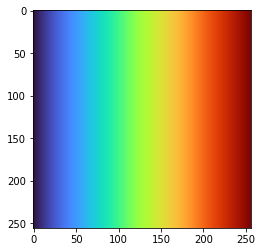

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import colormap

# 컬러맵을 정사각형 이미지로 변환해서 보여줍니다.
_=plt.imshow(np.array([colormap.MATRIX] * 256)) 

## INPUT  
input data definition   
  
> Data Type: 외부로부터 들어오는 바이너리 데이터입니다.  

In [2]:
DSM:bytes = open("input/sample_dsm.tif","rb").read()
ORTHOMOSAIC:bytes = open("input/sample_orthomosaic.tif","rb").read()

## Surface2Color  
``` rgba_matrix = Surface2Color(dsm_matrix).transform() ```  
  
* 컬러맵은 256개의 요소로 이루어진 리스트입니다. 0~255 인덱스로 접근하며, 인덱스가 255에 가까울수록 높은 Z값을 표현해줍니다.  
1. DSM의 픽셀(Z값)에 곱하면 컬러맵 인덱스가 나오게 해주는 미지수 n을 구합니다. -> DSM_pixel x n = colormap_index 
2. 모든 픽셀에 대해서 Z값(DSM 픽셀)을 RGBA채널로 변환시키는 연산을 수행합니다.  
    * ```if z == 결측치: return (0,0,0,0) else: return colormap[ round(z x n) ]```   
    * 수 억 번의 연산을 2~3분 안에 처리하는 방법 - 연산 병렬화( [pandarallel](https://towardsdatascience.com/pandaral-lel-a-simple-and-efficient-tool-to-parallelize-your-pandas-operations-on-all-your-cpus-bb5ff2a409ae) 사용 )  
        * pd.DataFrame(dsm_matrix).parallel_applymap  
        * DataFrame -> 3D array 변환 (flatten & reshape)  
    * 여기에서 사용하는 셈플은 1억 6930만 7930개의 픽셀로 이루어져 있습니다.  

In [3]:
from typing import Iterable
from importlib import import_module

import numpy as np
import pandas as pd
from pandarallel import pandarallel

class Surface2Color:
    """DSM(digital surface model) 매트릭스를 PNG(rgba) 매트릭스로 변환합니다."""

    MISSING_VALUE = -10000 # z 
    FEATURE_RANGE = 255 # 0~255 (colormap max index)
    MISSING_PIXEL = (0,0,0,0) # rgba 
    COLOR_MAP = import_module("colormap").MATRIX 

    def __init__(self,matrix:Iterable):
        """ fit 함수를 겸합니다. """

        self._n = self._calculation_n(matrix)
        self.data_frame = pd.DataFrame(matrix)
    
    def transform(self) -> pd.DataFrame:
        """ Z DataFrame -> RGBA DataFrame """

        pandarallel.initialize()
        rgba_df = self.data_frame.parallel_applymap(self._proc_unit)
        rgba_flatten = np.array([list(rgba) for rgba in rgba_df.to_numpy().flatten()]).flatten()
        rgba_shape = self.data_frame.shape + (4,)
        return rgba_flatten.reshape(rgba_shape).astype(np.uint8)
    
    def _proc_unit(self,z:float) -> np.array:
        """ z 값을 rgba로 변환합니다. """
        
        if z == self.MISSING_VALUE:
            return self.MISSING_PIXEL
        if self._min_v < 0: 
            z += abs(self._min_v) # 양수화
        normalized_value = z * self._n
        return self.COLOR_MAP[round(normalized_value)]

    def _calculation_n(self,matrix) -> float:
        """ nomalization 을 위한 숫자 n을 구합니다 """

        values = list(np.unique(np.array(matrix).flatten()))
        values.remove(self.MISSING_VALUE)
        self._min_v , self._max_v = min(values), max(values)
        self._pas_max_v = self._max_v + ( abs(self._min_v) if self._min_v < 0 else 0 ) # 양수화된 분포의 최대값

        return self.FEATURE_RANGE / self._pas_max_v

## Ready  
실행을 위한 준비: 이미지 바이너리 객체를 pillow Image 객체로 만듭니다  

In [4]:
import io

import numpy as np
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

dsm_img = Image.open(io.BytesIO(DSM))
orthomosaic_img = Image.open(io.BytesIO(ORTHOMOSAIC))

np.prod(dsm_img.size) # 처리해야 할 픽셀 갯수 (1억 6930만 7930)


169307930

***정사영상***

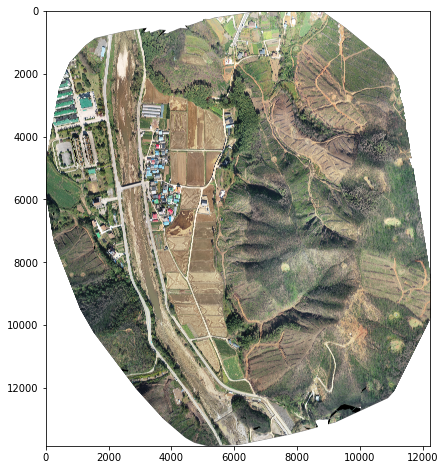

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
_=plt.imshow(orthomosaic_img)

***DSM (DSM을 Grayscale로 표현한 이미지)***

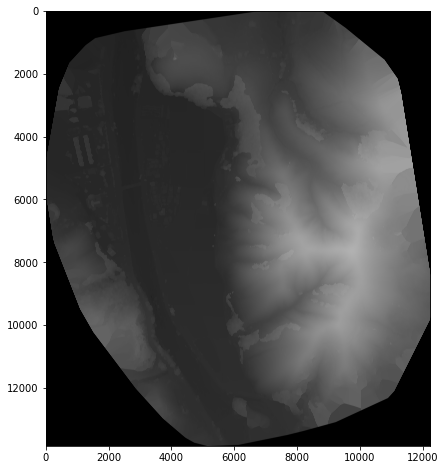

In [6]:
plt.figure(figsize=(8,8))
_=plt.imshow(dsm_img)

## Colorization - output: DSM RGBA Matrix  

Z값만 담긴 2차원 매트릭스를 색상화된 3차원 RGBA 매트릭스로 변환합니다.   

In [7]:
dsm_z_matrix = np.array(dsm_img)
dsm_rgba_matrix = Surface2Color(dsm_z_matrix).transform()

dsm_z_matrix.shape , dsm_rgba_matrix.shape 

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


((13838, 12235), (13838, 12235, 4))

***DSM Colorization Image***

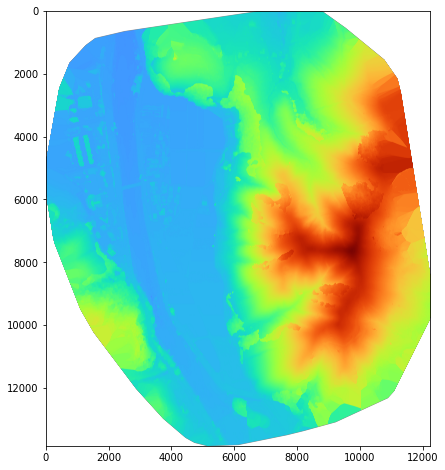

In [8]:
plt.figure(figsize=(8,8))
_=plt.imshow(dsm_rgba_matrix)

## Tiling for TMS protocol - output: Colorized DSM Tiles    
색상화된 DSM 타일화    
> [TMS : Tile Map Service](https://wiki.openstreetmap.org/wiki/TMS)  

In [9]:
from gdal2tiles import generate_tiles

# 결과가 저장될 경로들
COLORIZED_DSM_PATH = "output/colorized_dsm.tif" 
TILE_PATH = "output/tiles"

dsm_rgba_img = Image.fromarray(dsm_rgba_matrix)
dsm_rgba_img.save(COLORIZED_DSM_PATH, save_all=True, tiffinfo=orthomosaic_img.tag_v2) # 정사영상(orthomosaic_img)의 메타데이터 복사

generate_tiles(COLORIZED_DSM_PATH,TILE_PATH, zoom=[0,20])

Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Overview Tiles:
0...10...20...30...40...50...60...70...80...90...100


#### [타일화 결과 보기](output/tiles)  

최종 처리 결과입니다.  
DSM(수치 표고 모델) 데이터를 색상화 이미지로 타일화한 것이며  
타일링 기법을 구현하기 위해서 브라우저에게 TMS protocol에 적합한 데이터(최종 처리 결과)를 제공할 수 있게 되었습니다.  
  
타일들은 이제 Google MAP의 지리정보와 호환되어 정사영상이 촬영된 실제 위치에 표시되며  
사용자가 확대 축소를 함에 따라서 적합한 LOD(level of detail)가 적용된 타일들을 서빙합니다.  